In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from math import sqrt
import QGOpt as qgo
import numpy as np
from tqdm import tqdm

ModuleNotFoundError: No module named 'QGOpt'

#### Parameters of an experiment.

In [91]:
#=============================================#
num_of_qubits = 2  # number of qubits
num_of_meas = 600000  # number of measurements
#=============================================#

#### Many qubits IC POVM.

In [92]:
def kron(A, B):
    """Kronecker product of two tensors
    Args:
        A: tf tensor of shape (q, n, k)
        B: tf tensor of shape (p, m, l)
    Returns:
        tf tensor of shape (q * p, n * m, k * l)"""
    AB = tf.tensordot(A, B, axes=0)
    AB = tf.transpose(AB, (0, 3, 1, 4, 2, 5))
    shape = AB.shape
    AB = tf.reshape(AB, (shape[0] * shape[1],
                         shape[2] * shape[3],
                         shape[4] * shape[5]))
    return AB

# Pauli matrices
sigma_x = tf.constant([[0, 1], [1, 0]], dtype=tf.complex128)
sigma_y = tf.constant([[0 + 0j, -1j], [1j, 0 + 0j]], dtype=tf.complex128)
sigma_z = tf.constant([[1, 0], [0, -1]], dtype=tf.complex128)

# All Pauli matrices in one tensor
sigma = tf.concat([sigma_x[tf.newaxis],
                   sigma_y[tf.newaxis],
                   sigma_z[tf.newaxis]], axis=0)

# coordinates of thetrahedron peaks
s0 = tf.constant([0, 0, 1], dtype=tf.complex128)
s1 = tf.constant([2 * sqrt(2) / 3, 0, -1/3], dtype=tf.complex128)
s2 = tf.constant([-sqrt(2) / 3, sqrt(2 / 3), -1 / 3], dtype=tf.complex128)
s3 = tf.constant([-sqrt(2) / 3, -sqrt(2 / 3), -1 / 3], dtype=tf.complex128)

# coordinates of thetrahedron peaks in one tensor
s = tf.concat([s0[tf.newaxis],
               s1[tf.newaxis],
               s2[tf.newaxis],
               s3[tf.newaxis]], axis=0)

# One qubit thetrahedral POVM
M = 0.25 * (tf.eye(2, dtype=tf.complex128) + tf.tensordot(s, sigma, axes=1))

# Many qubits POVM
Mmq = M
for _ in range(num_of_qubits - 1):
    Mmq = kron(Mmq, M)

#### Data set generation (measurement outcomes simulation).

In [93]:
# random Kraus set
V = tf.random.normal((2 ** (3 * num_of_qubits), 2 ** num_of_qubits, 2), dtype=tf.float64)
V = qgo.manifolds.real_to_complex(V)
V, _ = tf.linalg.qr(V)
V = tf.reshape(V, (2 ** (2 * num_of_qubits), 2 ** num_of_qubits, 2 ** num_of_qubits))

# Bell state
bell_psi = tf.eye(2 ** num_of_qubits, dtype=tf.complex128)
bell_rho = tf.tensordot(bell_psi, tf.math.conj(bell_psi), axes=0)

# true Choi matrix
choi_true = tf.einsum('qij,qkl,ajbl->aibk', V, tf.math.conj(V), bell_rho)
choi_true = tf.reshape(choi_true, (2 ** (2 * num_of_qubits), 2 ** (2 * num_of_qubits)))

# random initial dens. matrices
psi_set = tf.random.normal((num_of_meas, 2 * num_of_qubits, 2), dtype=tf.float64)
psi_set = qgo.manifolds.real_to_complex(psi_set)
psi_set = psi_set / tf.linalg.norm(psi_set, axis=1)[:, tf.newaxis]
rho_set = psi_set[..., tf.newaxis] * tf.math.conj(psi_set[:, tf.newaxis])

# dens. matrices after aplication of a random channel
out_rho = tf.einsum('kij,klm,qjm->qil', V, tf.math.conj(V), rho_set)

# Measurements simulation
P = tf.cast(tf.einsum('qjk,pkj->pq', Mmq, out_rho), dtype=tf.float64)
eps = tf.random.uniform((num_of_meas,
                         2 ** (2 * num_of_qubits)),
                        dtype=tf.float64)
eps = -tf.math.log(-tf.math.log(eps))
ind_set = tf.math.argmax(eps + tf.math.log(P), axis=-1)

# Data set (projectors came true)
M_set = tf.gather_nd(Mmq, ind_set[:, tf.newaxis])


true_llh = -tf.reduce_sum(tf.math.log(tf.linalg.trace(out_rho @ M_set)))

#### Optimization loop maximizes the logarithmic likelihood function.

In [94]:
# Parameters of learning
#=========================================#
lr = 0.07  # learning rate
num_of_iter = 400  # number of iterations
#=========================================#

# Initial choi matrix
choi = tf.random.normal((2 ** (3 * num_of_qubits), 2 ** num_of_qubits, 2), dtype=tf.float64)
choi = qgo.manifolds.real_to_complex(choi)
choi, _ = tf.linalg.qr(choi)
choi = tf.transpose(choi)
choi = tf.reshape(choi, (2 ** (2 * num_of_qubits), 2 ** (2 * num_of_qubits)))
choi = qgo.manifolds.complex_to_real(choi)
choi = tf.Variable(choi)

# optimizer initialization
m = qgo.manifolds.ChoiMatrix() # S++ manifold
opt = qgo.optimizers.RAdam(m, lr) # riemannian optimizer

dist = []  # to be filled by trace distance vs iteration
losses = []  # to be filled by loss vs iteration

for _ in tqdm(range(num_of_iter)):
    with tf.GradientTape() as tape:
        choi_c = qgo.manifolds.real_to_complex(choi)
        choi_c = tf.reshape(choi_c, (2 ** num_of_qubits,
                                     2 ** num_of_qubits,
                                     2 ** (2 * num_of_qubits)))
        choi_c = tf.tensordot(choi_c, tf.math.conj(choi_c), [[2], [2]])
        current_choi = tf.reshape(choi_c, (2 ** (2 * num_of_qubits), 2 ** (2 * num_of_qubits)))
        choi_c = tf.transpose(choi_c, (1, 3, 0, 2))
        choi_c = tf.reshape(choi_c, (2 ** (2 * num_of_qubits), 2 ** (2 * num_of_qubits)))
        rho_set_resh = tf.reshape(rho_set, (-1, 2 ** (2 * num_of_qubits)))
        rho_out_resh = tf.tensordot(choi_c, rho_set_resh, [[1], [1]])
        rho_out_resh = tf.transpose(rho_out_resh)
        rho_out = tf.reshape(rho_out_resh, (-1, 2 ** num_of_qubits, 2 ** num_of_qubits))
        p = tf.abs(tf.linalg.trace(M_set @ rho_out))
        loss = -tf.reduce_mean(tf.math.log(p))  # negatibe log likelihood
    grad = tape.gradient(loss, choi)  # gradient
    opt.apply_gradients(zip([grad], [choi]))  # optimization step
    losses.append(loss)
    dist.append(0.5 * tf.reduce_sum(tf.abs(tf.linalg.eigvalsh(current_choi - choi_true))))
np.save('qubits=' + str(num_of_qubits) + '.npy', dist)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:52<00:00,  2.32it/s]


#### Plotting trace distance vs number of iter

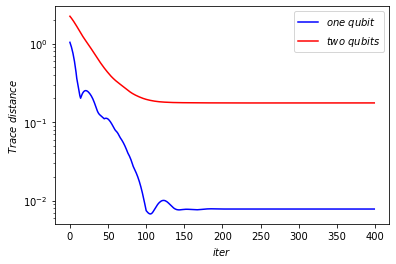

In [112]:
plt.plot(np.load('qubits=1.npy') / 2, 'b')
plt.plot(np.load('qubits=2.npy') / 4, 'r')
plt.legend([r'$one \ qubit$', r'$two \ qubits$'])
plt.yscale('log')
plt.ylabel(r'$Trace \ distance$')
plt.xlabel(r'$iter$')
plt.savefig('trace_distance_vs_iter.pdf')

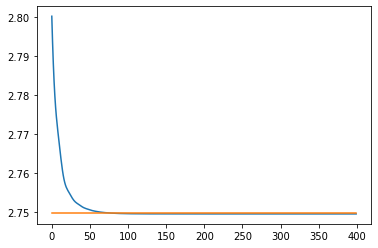

In [101]:
plt.plot(losses)
plt.plot([true_llh / 600000] * 400)